#### 09 fevereiro 2021
# Seminário de Python
### Como irá evoluir o Turismo em Portugal no período 2021-2023?
Após uma forte década de crescimento entre 2010 e 2020, o turismo em Portugal viu-se ameaçado pelo surgimento da pandemia de covid-19, que restringiu de forma bastante severa as deslocações de visitantes ao país.
De que forma poderão ser utilizados os dados disponibilizados pelo Turismo de Portugal, para prever o comportamento do turismo nos próximos anos, e auxiliar as entidades a delinear um plano de recuperação para cada região do país?

![Image of Yaktocat](https://www.nit.pt/wp-content/uploads/2020/03/0fbf72dcd7cd63698f1e6fcd636d5dfa-754x394.jpg)

### 1. Início - Importação de dados e de bibliotecas

In [14]:
import pandas as pd
import os
from matplotlib import interactive
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
lista_excel = os.listdir('Info')
lista_mercado = [i for i in lista_excel if 'mercado' in i]
lista_mercado

['hospedes_mercado (2010-2013).xlsx',
 'hospedes_mercado (2014-2018).xlsx',
 'hospedes_mercado (2019-2020).xlsx']

In [3]:
lista_df = []
for fic in lista_mercado:
    years = fic.split('(')[1].split(')')[0].split('-')
    list_years = list(range(int(years[0]),int(years[1]) + 1))
    for year in list_years:
        year = str(year)
        df = pd.read_excel(f'Info\\{fic}', sheet_name = year, skiprows = 3, header = 0, index_col = 0)
        line = [i for i,x in enumerate(df.index) if x == 'Total Global'][0]
        df = df.iloc[:line + 1]
        df['Ano'] = year
        lista_df.append(df)

In [4]:
total = pd.concat(lista_df)
total

,janeiro,fevereiro,março,abril,maio,junho,julho,agosto,setembro,outubro,novembro,dezembro,Acumulado,Ano
Norte,143497,149713,175512,209075,236332,214698,253193,307298,271679,241209,173978,169727,2545911,2010
Alemanha,2153,2817,4574,5062,8361,6434,5425,5303,9032,7485,3795,2492,62933,2010
Bélgica,789,759,1125,1652,2477,2191,3180,2381,2892,2019,1570,727,21762,2010
Brasil,4445,4154,4006,5641,8053,6675,9097,5890,10486,9786,4730,4586,77549,2010
Escandinávia,543,627,1345,1343,2319,1735,2690,1366,2981,2912,1108,1140,20109,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Suécia,3343,3737,2323,_,_,1,31,NaN,NaN,NaN,NaN,NaN,9435,2020
Suíça,1210,1353,873,1,2,5,553,NaN,NaN,NaN,NaN,NaN,3997,2020
Outros Estrangeiros,8867,9471,5752,3,5,31,869,NaN,NaN,NaN,NaN,NaN,24998,2020
Portugal,19894,22650,10839,64,846,5317,15841,NaN,NaN,NaN,NaN,NaN,75451,2020


### 2 Análise exploratória de dados (EDA) - por região do país e por mercado

In [7]:
regioes = ['Norte','Centro','A.M. Lisboa', 'Alentejo', 'Algarve', 'Açores', 'Madeira']
total = total.replace('_', 0).fillna(0)
for i in total.columns:
    if i != 'index':
        total[i] = total[i].astype(int)
total = total.reset_index()
total

,index,janeiro,fevereiro,março,abril,maio,junho,julho,agosto,setembro,outubro,novembro,dezembro,Acumulado,Ano
0,Norte,143497,149713,175512,209075,236332,214698,253193,307298,271679,241209,173978,169727,2545911,2010
1,Alemanha,2153,2817,4574,5062,8361,6434,5425,5303,9032,7485,3795,2492,62933,2010
2,Bélgica,789,759,1125,1652,2477,2191,3180,2381,2892,2019,1570,727,21762,2010
3,Brasil,4445,4154,4006,5641,8053,6675,9097,5890,10486,9786,4730,4586,77549,2010
4,Escandinávia,543,627,1345,1343,2319,1735,2690,1366,2981,2912,1108,1140,20109,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,Suécia,3343,3737,2323,0,0,1,31,0,0,0,0,0,9435,2020
1134,Suíça,1210,1353,873,1,2,5,553,0,0,0,0,0,3997,2020
1135,Outros Estrangeiros,8867,9471,5752,3,5,31,869,0,0,0,0,0,24998,2020
1136,Portugal,19894,22650,10839,64,846,5317,15841,0,0,0,0,0,75451,2020


### 2.1 Qual é a média de visitantes anuais por região?

In [25]:
(
    total.query('index == @regioes').groupby('index')['Acumulado'].mean()
    .sort_values(ascending = False)
).astype(int)

index
A.M. Lisboa    5276688
Norte          3593506
Algarve        3539608
Centro         2715627
Madeira        1187080
Alentejo        972458
Açores          446214
Name: Acumulado, dtype: int32

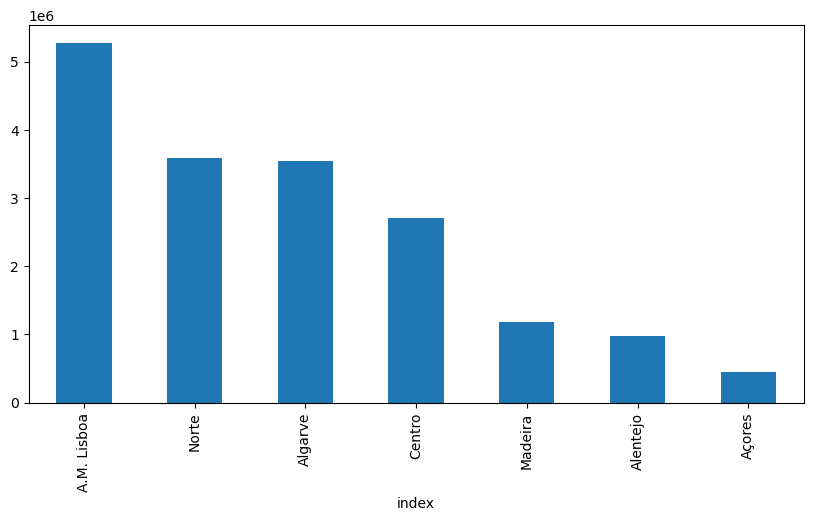

In [22]:
(
    total.query('index == @regioes').groupby('index')['Acumulado'].mean()
    .sort_values(ascending = False)
).plot.bar()

### 2.2 Crescimento médio anual (CAGR) por região

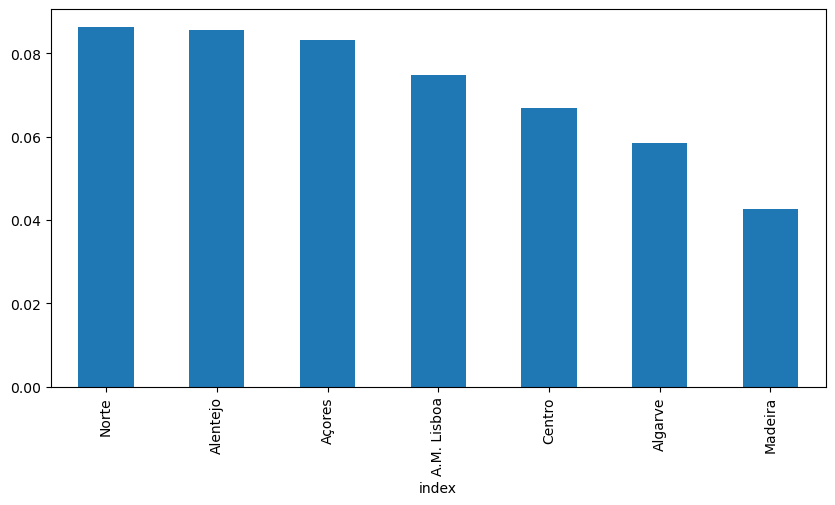

In [20]:
def CAGR(lista):
    return (lista[-1] / lista[0]) ** (1 / len(lista)) - 1

(
    total.query('index == @regioes')
    .pivot_table(index = 'index', columns = 'Ano', values = 'Acumulado', aggfunc = sum)
    .apply(lambda x: CAGR([x[y] for y in range(2010,2020)]), axis = 1)
).sort_values(ascending = False).plot.bar()

### 2.3 Visualização da evolução de hóspedes por região

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000256C350B188>,
      dtype=object)

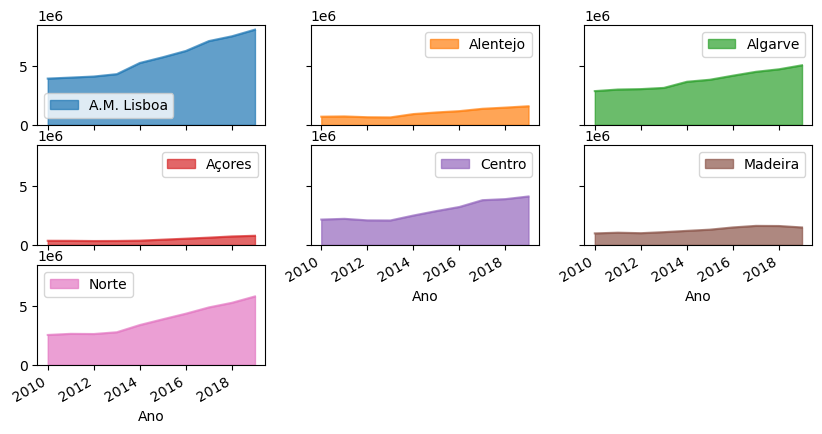

In [26]:
(
    total.query('index == @regioes and Ano < 2020')
    .pivot_table(index = 'Ano', columns = 'index', values = 'Acumulado', aggfunc = 'sum')
).plot.area(subplots = True, alpha = 0.7, sharey = True, layout = (3,3))

### 2.4 Qual é a média de visitantes anuais por mercado?

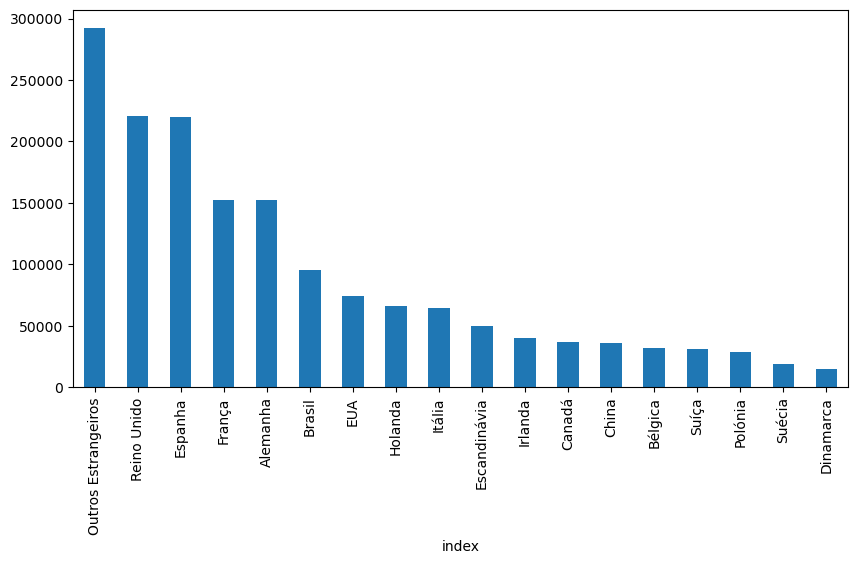

In [29]:
(
    total.query('index != @regioes and index != "Total Global" & index != "Portugal"')
    .groupby('index')['Acumulado'].mean()
    .sort_values(ascending = False)
).plot.bar()

### 2.5 Crescimento médio anual (CAGR) por região

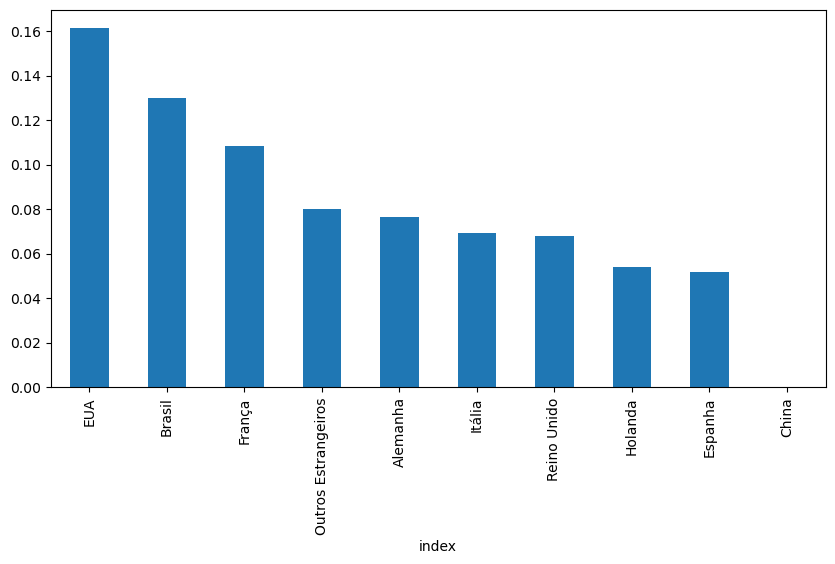

In [42]:
(
    total.query('index != @regioes and index != "Total Global" & index != "Portugal"')
    .pivot_table(index = 'index', columns = 'Ano', values = 'Acumulado', aggfunc = sum)
    .sort_values(ascending = False, by = 2020)
    .iloc[:10]
    .apply(lambda x: CAGR([x[y] for y in range(2010,2020)]), axis = 1)
).sort_values(ascending = False).plot.bar()

### 2.6 Visualização da evolução de hóspedes por mercado

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000256C4EEE0C8>,
      dtype=object)

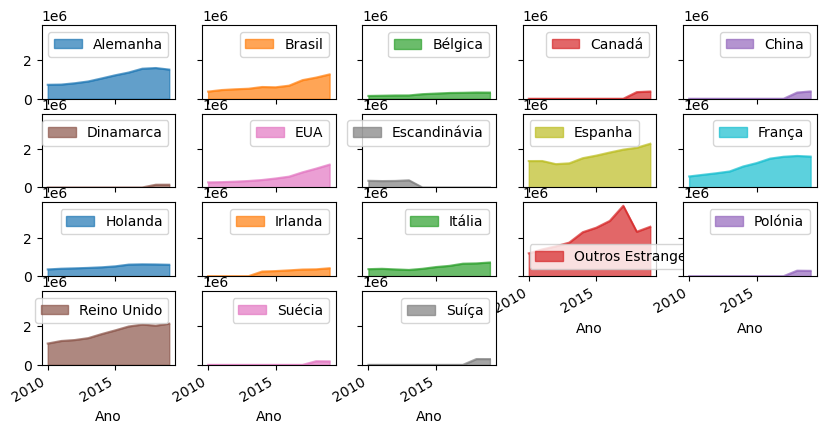

In [43]:
(
    total.query('index != @regioes and Ano < 2020 and index != "Total Global" and index != "Portugal"')
    .pivot_table(index = 'Ano', columns = 'index', values = 'Acumulado', aggfunc = 'sum')
).plot.area(subplots = True, alpha = 0.7, sharey = True, layout = (4,5))

## 3. Previsão do total de visitantes

2010-01-31     669265
2010-02-28     732526
2010-03-31     919591
2010-04-30    1138254
2010-05-31    1288756
               ...   
2020-08-31          0
2020-09-30          0
2020-10-31          0
2020-11-30          0
2020-12-31          0
Freq: M, Length: 132, dtype: int64

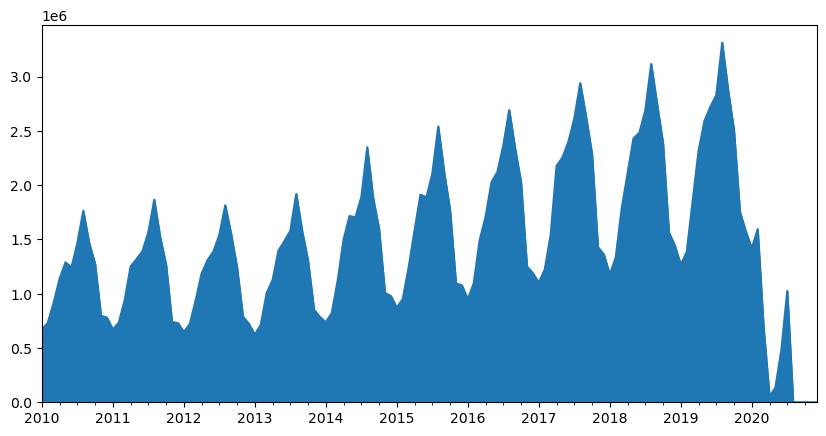

In [46]:
values = total.drop(columns = ['Acumulado','Ano']).query('index == "Total Global"').drop(columns = 'index').values.tolist()
values_flat = [item for sublist in values for item in sublist]
ts = pd.Series(values_flat, index = pd.date_range(start = '1/1/2010', end = '1/1/2021', freq = 'M'))
ts.plot.area()
ts

Os dados existem até julho de 2020

Vamos tentar prever a partir de jan 2020 normalmente, e analisar o que aconteceu para tentar extrapolar os resultados.

c:\users\jose.guimaraes\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.
c:\users\jose.guimaraes\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
c:\users\jose.guimaraes\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


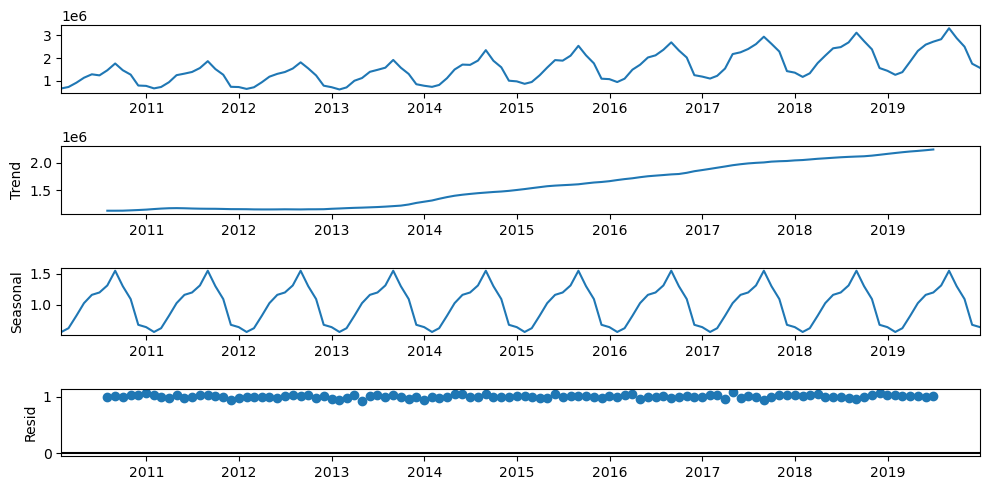

In [47]:
seasonal_decompose(ts[:-12], model='multiplicative', freq=12).plot()
model = ExponentialSmoothing(ts[:-12], seasonal = 'add', seasonal_periods = 12, trend = 'mul')
model_fit = model.fit()

In [49]:
actual = ts[-12:].values
forecast = pd.Series(model_fit.forecast(36).values, index = pd.date_range(start = '1/1/2020', end = '1/1/2023', freq = 'M'))

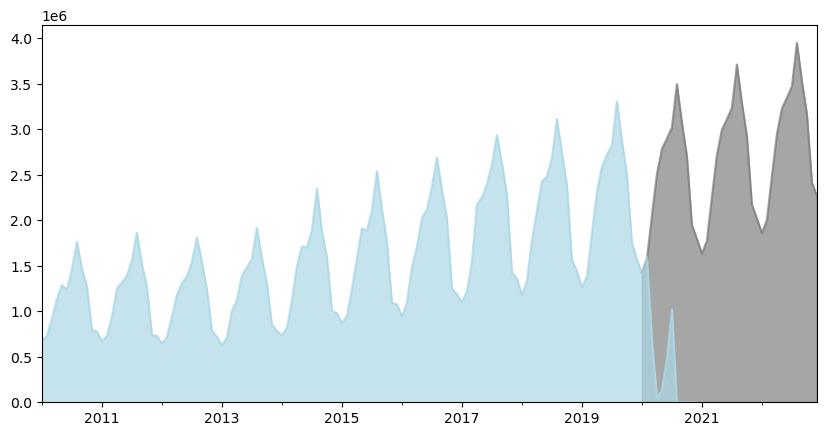

In [51]:
forecast.plot.area(color = 'gray', alpha = 0.7)
ts.plot.area(color = 'lightblue', alpha = 0.7)

### Fomos arruinados pela Covid-19... O que podemos fazer daqui para a frente?
Vamos projetar o mesmo crescimento esperado para os próximos 3 anos, e abater com uma taxa de queda estável

Análise de cenários:
1. Cenário 1 - usar os dados conhecidos (Fev-Jun) como aproximação para a taxa de queda esperada nos próximos 3 anos
2. Cenário 2 - usar os dados de planos de vacinas para estimar a taxa de queda a cada momento
3. Cenário 3 - usar um fator de medo, para estimar o efeito durável no tempo (havendo vacina, não voltamos imediatamente ao pré-covid)

### Cenário 1. Dados para taxa de queda - tendo uma série estável, iremos comparar a previsão com o que aconteceu, assumindo que a previsão seria o real

In [53]:
sum(ts[-10:-5]) / sum(forecast[-10:-5])
queda = 1 - (sum(ts[-10:-5]) / sum(forecast[-10:-5]))
queda

0.8456824682746027

In [56]:
print(f'A nossa taxa de queda foi de {round(queda * 100,1)}% ')

A nossa taxa de queda foi de 84.6% 


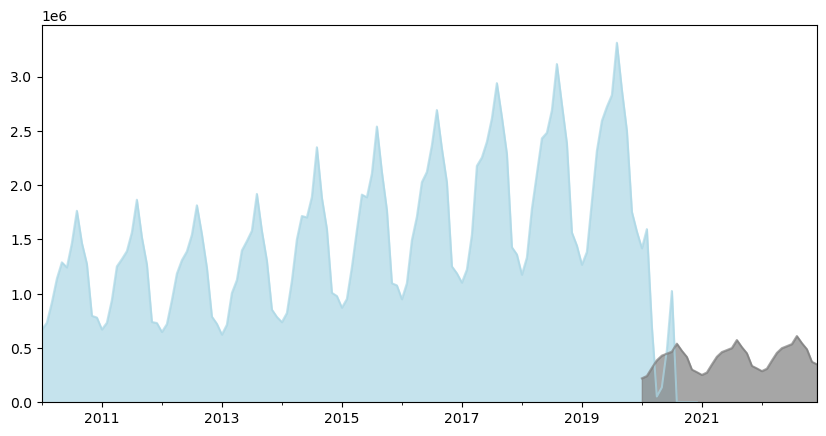

In [62]:
forecast_com_queda = forecast * (1 - queda)
ts.plot.area(color = 'lightblue', alpha = 0.7)
forecast_com_queda.plot.area(color = 'gray', alpha = 0.7)

### Cenário 2. Após consulta dos planos de vacinação, estimamos :
### 100% da taxa de queda em 2020, 50% em 2021 e 0% em 2022

In [58]:
df_forecast = forecast.reset_index()
df_forecast['ano'] = df_forecast['index'].map(lambda x: x.year)
df_forecast['taxa'] = df_forecast['ano'].map(lambda x: queda if x == 2020 else (queda * 0.5 if x == 2021 else 0))
df_forecast['forecast_vacina'] = df_forecast.apply(lambda x: x[0] * (1 - x['taxa']), axis = 1)
df_forecast = df_forecast.set_index('index')
df_forecast

,0,ano,taxa,forecast_vacina
index,,,,
2020-01-31,1.428717e+06,2020,0.845682,2.204761e+05
2020-02-29,1.569087e+06,2020,0.845682,2.421376e+05
2020-03-31,2.050357e+06,2020,0.845682,3.164060e+05
2020-04-30,2.506572e+06,2020,0.845682,3.868080e+05
2020-05-31,2.784591e+06,2020,0.845682,4.297113e+05
2020-06-30,2.900831e+06,2020,0.845682,4.476491e+05
2020-07-31,3.021167e+06,2020,0.845682,4.662191e+05
2020-08-31,3.497364e+06,2020,0.845682,5.397046e+05
2020-09-30,3.071428e+06,2020,0.845682,4.739752e+05


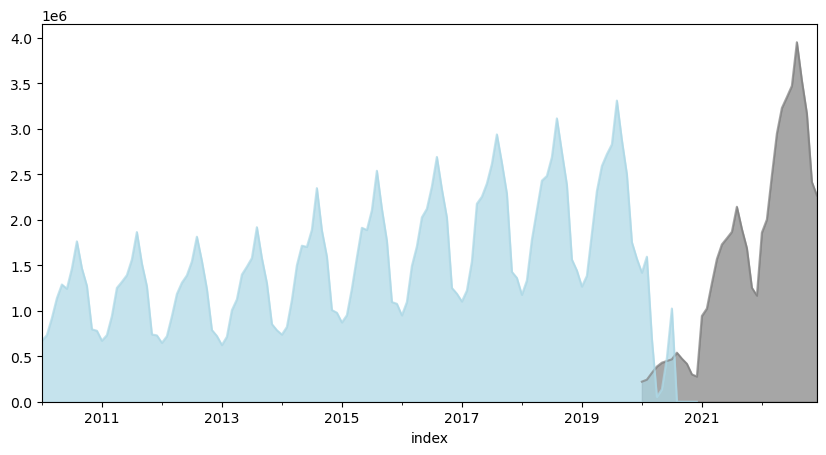

In [60]:
df_forecast['forecast_vacina'].plot.area(color = 'gray', alpha = 0.7)
ts.plot.area(color = 'lightblue', alpha = 0.7)

### Cenário 3. Infelizmente, haverá um período de medo, em que os viajantes não continuarão a viajar com tanta facilidade
função linear de medo, de 100% de medo até 0% de medo -> percentagem de pessoas que não viajará, face a uma situação normal

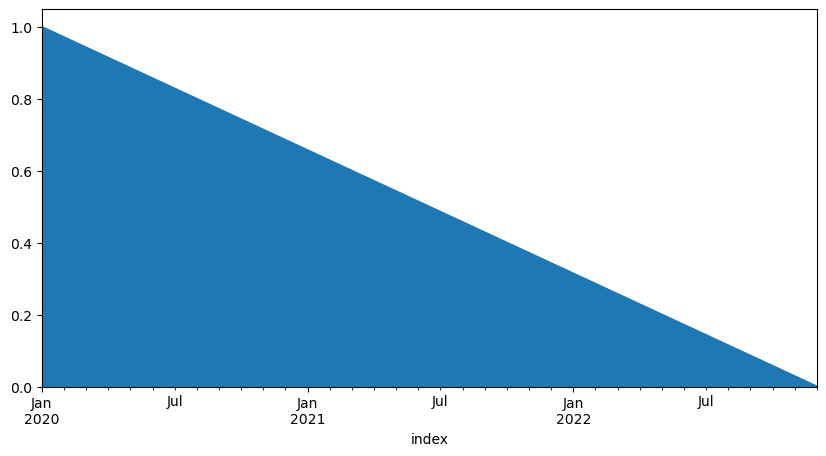

In [66]:
df_forecast['medo'] = [1 - (i / 35) for i in range(36)] 
df_forecast['medo'].plot.area()
df_forecast['forecast_vacina_medo'] = df_forecast.apply(lambda x: x['forecast_vacina'] * (1 - x['medo']), axis = 1)

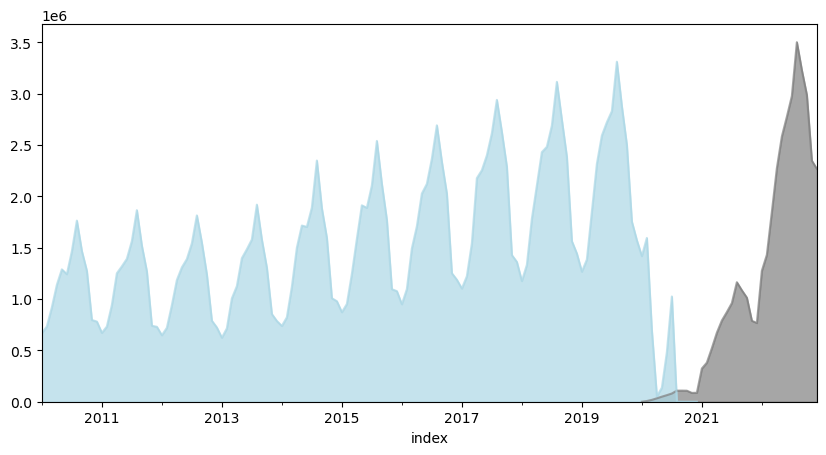

In [68]:
df_forecast['forecast_vacina_medo'].plot.area(color = 'gray', alpha = 0.7)
ts.plot.area(color = 'lightblue', alpha = 0.7)

E se o medo nunca passar totalmente, companhias aéreas demorarem a recuperar, negócios funcionarem via zoom cada vez mais?
### Cenário 3.1. Vamos estimar que só iremos até 75% do máximo

In [69]:
df_forecast['medo_75'] = [1 - (i / 35) * 0.75 for i in range(36)]
df_forecast['forecast_vacina_medo_75'] = df_forecast.apply(lambda x: x['forecast_vacina'] * (1 - x['medo_75']), axis = 1)

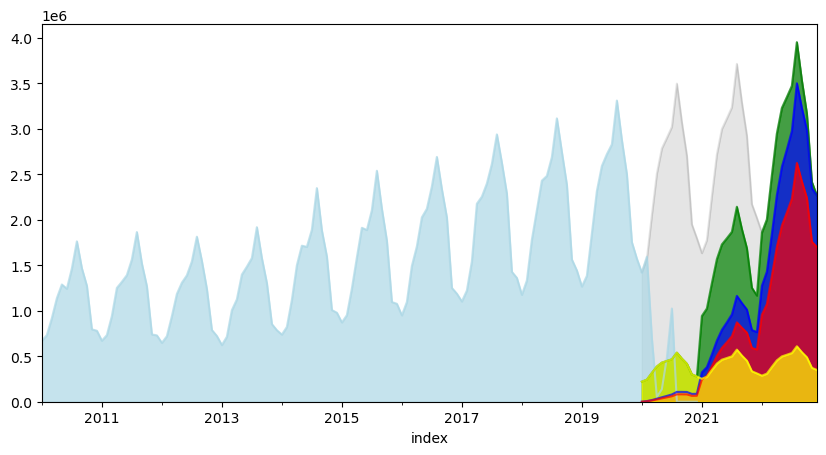

In [72]:
forecast.plot.area(color = 'gray', alpha = 0.2)
ts.plot.area(color = 'lightblue', alpha = 0.7)
df_forecast['forecast_vacina'].plot.area(color = 'green', alpha = 0.7)
df_forecast['forecast_vacina_medo'].plot.area(color = 'blue', alpha = 0.7)
df_forecast['forecast_vacina_medo_75'].plot.area(color = 'red', alpha = 0.7)
forecast_com_queda.plot.area(color = 'yellow', alpha = 0.7)

### Como calcular agora por região?
#### 1. Definir um período para cálculo de pesos para cada região - últimos 3 anos com dados, por ex
#### 2. Multiplicar a nossa previsão mais "razoável" pelo respetivo peso

In [74]:
total_regiao = total.query('index == @regioes and Ano >= 2018').groupby('index')['Acumulado'].mean().reset_index()
total_para_peso = total_regiao['Acumulado'].sum()
total_regiao['peso'] = total_regiao['Acumulado'] / total_para_peso
total_regiao = total_regiao.set_index('index')
total_regiao

,Acumulado,peso
index,,
A.M. Lisboa,5.727625e+06,0.298176
Alentejo,1.159241e+06,0.060349
Algarve,3.547694e+06,0.184690
Açores,5.360480e+05,0.027906
Centro,2.975280e+06,0.154891
Madeira,1.125856e+06,0.058611
Norte,4.137133e+06,0.215376


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000256C9F4D9C8>,
      dtype=object)

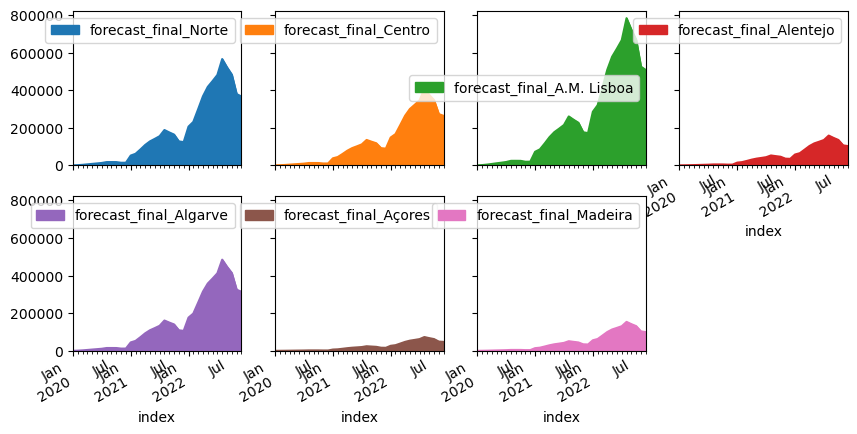

In [75]:
for i in regioes:
    df_forecast['forecast_final_' + i] = df_forecast['forecast_vacina_medo_75'] * total_regiao.loc[i,'peso']
    df_forecast['forecast_final_' + i] = df_forecast['forecast_final_' + i].map(lambda x: round(x, 0))

df_forecast.columns
df_forecast[['forecast_final_' + i for i in regioes]]
df_forecast[['forecast_final_' + i for i in regioes]].plot.area(subplots = True, sharey = True, layout = (2,4))